# Game Verifier

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: 
    !pip install -Uqq fastai

In [2]:
import re
import shutil
import subprocess
import time
from collections import Counter
from operator import itemgetter

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import requests
import timm
import torch
from dotenv import load_dotenv
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastcore.all import *
from torch import nn
from tqdm import tqdm

## Gathering Data

In [2]:
load_dotenv()

USERNAME = os.getenv('REDDIT_USERNAME')
PASSWORD = os.getenv('REDDIT_PASSWORD')
APP_ID = os.getenv('APP_ID')
APP_NAME = os.getenv('APP_NAME')
APP_SECRET = os.getenv('APP_SECRET')

In [3]:
def is_valid_gallery_url(url): 
    return isinstance(url, str) and re.match(r'https?://www.reddit.com/gallery/[a-z0-9]+', url)

def get_gallery_id(url): 
    return url.split('/')[-1]

In [4]:
# Official Reddit API, requires auth
REDDIT_PUB_URL = 'https://www.reddit.com/'
REDDIT_OUTH_URL = 'https://oauth.reddit.com/'

def get_api_token(): 
    data = {'grant_type': 'password', 'username': USERNAME, 'password': PASSWORD}
    auth = requests.auth.HTTPBasicAuth(APP_ID, APP_SECRET)
    r = requests.post(REDDIT_PUB_URL + 'api/v1/access_token',
                      headers={'user-agent': f'{APP_NAME} by {USERNAME}'},
                      data=data, auth=auth)
    d = r.json()
    return 'bearer ' + d['access_token']

def get_posts_reddit(subreddit, token, **params): 
    headers = {'Authorization': token, 'User-Agent': f'{APP_NAME} by {USERNAME}'}
    response = requests.get(REDDIT_OUTH_URL + f'r/{subreddit}/new.json', headers=headers, params=params)
    if response.status_code == 200: 
        return response.json()['data']
    else: 
        raise Exception(f'Request failed with status code {response.status_code}')

def get_gallery_urls_reddit(subreddit, token, classes, limits=100, start=None): 
    urls = [[] for _ in classes]
    limits = list(limits) if hasattr(limits, '__iter__') else [limits] * len(classes)
    cur_time = int(start if start else time.time())
    while np.any(limits):
        posts = get_posts_reddit(subreddit, token, limit=100, before=cur_time)
        for post in posts['children']: 
            post = post['data']
            cur_time = int(post['created_utc'])
            label, url = post['link_flair_text'], post['url']
            if post['locked'] and label in classes and is_valid_gallery_url(url):
                index = classes.index(label)
                if limits[index]:
                    urls[index].append(url)
                    limits[index] -= 1
    return urls

In [5]:
# Thrid-party PullPush API, no auth
PULLPUSH_URL = "https://api.pullpush.io/reddit/search/submission/"

def get_posts_pullpush(subreddit, **kwargs): 
    params = {'subreddit': subreddit, **kwargs}
    response = requests.get(PULLPUSH_URL, params=params)
    return response.json()

def get_gallery_urls_pullpush(subreddit, classes, limits=100, start=None): 
    urls = [[] for _ in classes]
    limits = list(limits) if hasattr(limits, '__iter__') else [limits] * len(classes)
    cur_time = int(start if start else time.time())
    while np.any(limits): 
        posts = get_posts_pullpush(subreddit, locked=True, size=100, before=cur_time)
        for post in posts['data']:
            cur_time = int(post['created_utc'])
            label, url = post['link_flair_text'], post['url']
            if label in classes and is_valid_gallery_url(url):
                index = classes.index(label)
                if limits[index]:
                    urls[index].append(url)
                    limits[index] -= 1
    return urls

In [ ]:
token = get_api_token()
token

In [3]:
SUBREDDIT = "gameverifying"
CLASSES = ['Legitimate', 'Fake']
LIMIT = 100

In [ ]:
# Using Official Reddit API
urls = get_gallery_urls_reddit(SUBREDDIT, token, CLASSES, LIMIT)

In [7]:
# Using Third-party Pullpush API
urls = get_gallery_urls_pullpush(SUBREDDIT, CLASSES, LIMIT)

In [8]:
for cls, links in zip(CLASSES, urls):
    print(f'{cls}: {len(links)}')

Legitimate: 100
Fake: 100


In [9]:
def download_gallery_images(urls, path):
    path = Path(path)
    for url in tqdm(urls): 
        id = get_gallery_id(url)
        dirname = path / id
        dirname.mkdir(exist_ok=True, parents=True)
        subprocess.Popen(['gallery-dl', url, '-D', dirname], 
                         stdout=subprocess.DEVNULL, 
                         stderr=subprocess.DEVNULL)

In [4]:
DATA_DIR = Path('/kaggle/input/game-verifier-data' if iskaggle else '.')
ROOT_DIR = DATA_DIR / 'images'

In [18]:
shutil.rmtree(ROOT_DIR, ignore_errors=True)
for cls, links in zip(CLASSES, urls): 
    download_gallery_images(links, ROOT_DIR / cls.lower())

100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


In [19]:
fnames = get_image_files(ROOT_DIR)
failed = verify_images(fnames)
failed.map(Path.unlink)
len(failed)

0

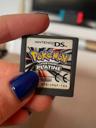

In [20]:
img = Image.open(fnames[0])
img.to_thumb(128,128)

## Cleaning Data

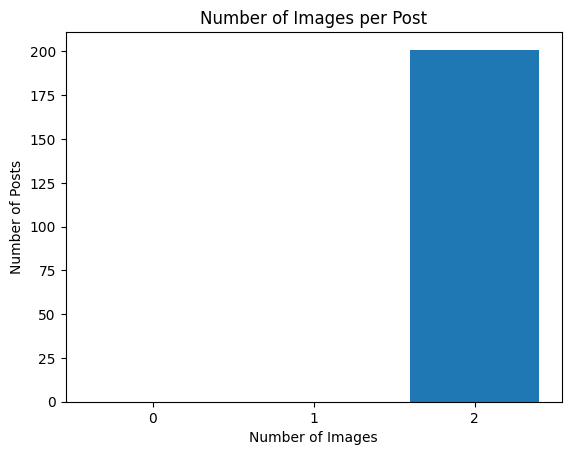

In [5]:
def get_gallery_dirs(root_dir): 
    return np.concatenate([(root_dir / cls.lower()).ls() for cls in CLASSES])

gal_dirs = get_gallery_dirs(ROOT_DIR)
img_cnts = {d : len(get_image_files(d)) for d in gal_dirs}

max_cnt = max(img_cnts.values())
counter = Counter(img_cnts.values())

labels = list(range(max_cnt + 1))
freqs = list(map(counter.__getitem__, labels))

plt.bar(labels, freqs)

plt.title("Number of Images per Post")
plt.xlabel("Number of Images")
plt.ylabel("Number of Posts")
plt.xticks(labels)

plt.show()

In [6]:
top_cnts = sorted(img_cnts.items(), key=itemgetter(1), reverse=True)

for dirname, cnt in top_cnts[:10]: 
    print(f'{str(dirname).ljust(25)}\t{cnt}') 

images/legitimate/1966rrx	2
images/legitimate/1cigabb	2
images/legitimate/1abxy1p_3	2
images/legitimate/181xttg_1	2
images/legitimate/1bwiiz7	2
images/legitimate/1cp8qv2	2
images/legitimate/18guywh_2	2
images/legitimate/18guywh_1	2
images/legitimate/196cohf	2
images/legitimate/1967kyg_1	2


In [7]:
@delegates(ImagesCleaner)
class GalleryCleaner(GetAttr):
    def __init__(self, dirnames, **kwargs):
        self.default = self.iw = ImagesCleaner(**kwargs)
        self.dd_dnames = widgets.Dropdown(options=dirnames)
        self.btn_select = widgets.Button(description='Select All')
        self.btn_delete = widgets.Button(description='Delete')
        self.dd_dnames.observe(self.on_change_dir, names='value')
        self.btn_select.on_click(self.on_select_all)
        self.btn_delete.on_click(self.on_delete_all)
        self.on_change_dir()
        self.widget = VBox([self.dd_dnames, self.iw.widget,
                           self.btn_select, self.btn_delete])

    def _ipython_display_(self): display(self.widget)

    def on_change_dir(self, change=None):
        fnames = sorted(get_image_files(self.dd_dnames.value))
        self.iw.set_fns(fnames)

    def on_select_all(self, btn): 
        for dd in L(self.iw.widget.children).itemgot(1): 
            dd.value = '<Delete>'

    def on_delete_all(self, btn): 
        for idx in self.iw.delete(): 
            self.iw.fns[idx].unlink()
        self.on_change_dir()

In [16]:
cleaner = GalleryCleaner(L(top_cnts).itemgot(0))
cleaner

In [20]:
failed = list(map(shutil.rmtree, [d for d, c in img_cnts.items() if c == 0]))
len(failed)

1

In [18]:
def split_gallery(dirname):
    dirname = Path(dirname)
    fnames = sorted(get_image_files(dirname))
    for i in range(len(fnames) // 2):
        old_parent = fnames[2*i].parent
        new_parent = old_parent.with_name(
            f'{old_parent.name}_{i}') if i > 0 else old_parent
        new_parent.mkdir(exist_ok=True)
        shutil.move(fnames[2*i], new_parent / fnames[2*i].name)
        shutil.move(fnames[2*i+1], new_parent / fnames[2*i+1].name)
    if len(fnames) % 2 == 1:
        fnames[-1].unlink()

split = list(map(split_gallery, get_gallery_dirs(ROOT_DIR)))
len(split)

169

In [21]:
def rename_gallery_images(dirname):
    dirname = Path(dirname)
    fnames = sorted(get_image_files(dirname))
    for i in range(len(fnames)):
        ext = fnames[i].suffix
        fnames[i].rename(fnames[i].with_name(f'{(i+1):03}{ext}'))

renamed = list(map(rename_gallery_images, get_gallery_dirs(ROOT_DIR)))
len(renamed)

201

In [22]:
for cls in CLASSES: 
    cnt = len((ROOT_DIR / cls.lower()).ls())
    print(f'{cls}: {cnt}')

Legitimate: 117
Fake: 84


## Training Model

In [6]:
MODEL_DIR = Path('/kaggle/working/models' if iskaggle else 'models')

### Single Input

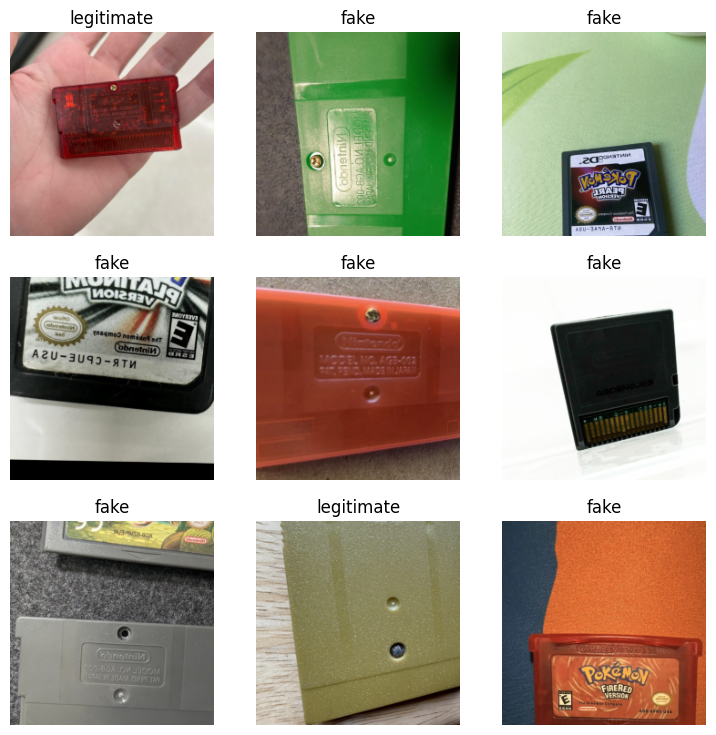

In [9]:
def label_func(x): return x.parent.parent.name 

dls = ImageDataLoaders.from_path_func(
    ROOT_DIR, get_image_files(ROOT_DIR), label_func, 
    valid_pct=0.2, 
    item_tfms=Resize(480), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75) 
)

dls.show_batch()

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate, model_dir=MODEL_DIR)

In [ ]:
learn.lr_find()

In [14]:
epoches, lr = 4, 3e-3
learn.fine_tune(epoches, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.246105,1.246097,0.376471,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.928500,0.670682,0.282353,00:43
1,0.827412,0.640176,0.223529,00:46
2,0.717801,0.648804,0.176471,00:40
3,0.685697,0.619826,0.152941,00:40


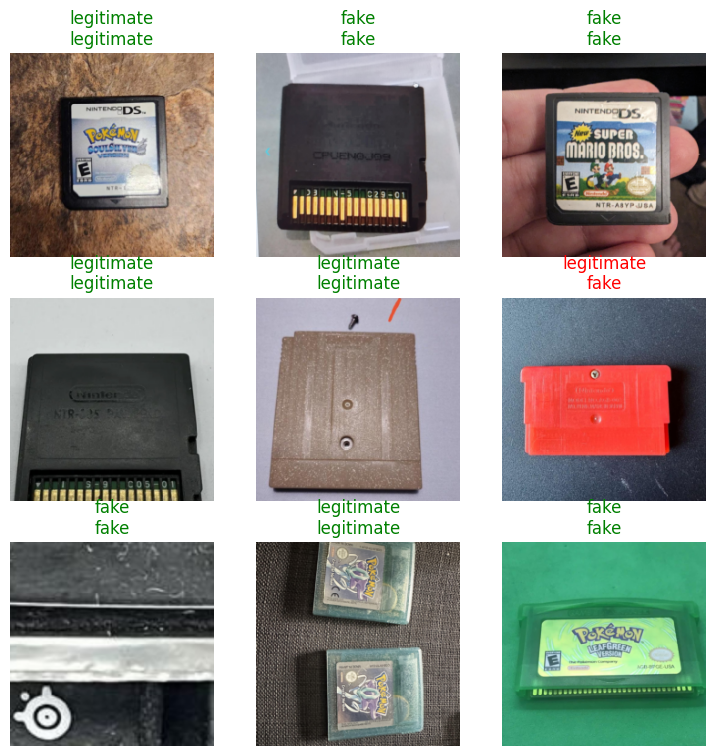

In [36]:
learn.show_results()

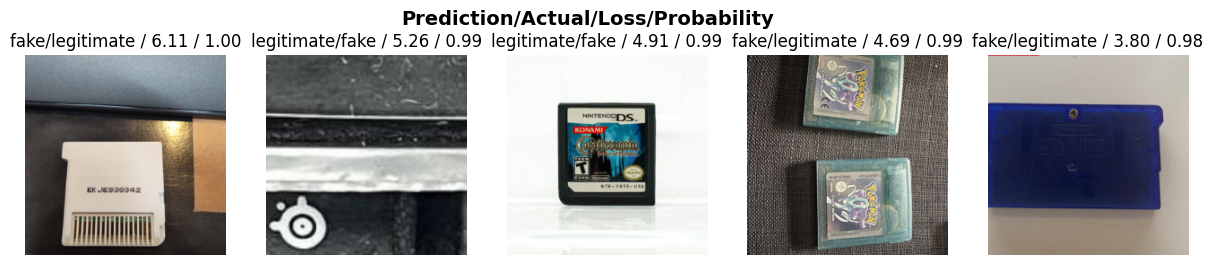

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)

### Dual Input

In [7]:
def get_front_image(dirname): return sorted(get_image_files(dirname))[0] 
def get_back_image(dirname):  return sorted(get_image_files(dirname))[1]

dblock = DataBlock(
    blocks=(ImageBlock, ImageBlock, CategoryBlock),
    n_inp=2,
    get_items=get_gallery_dirs,
    splitter=RandomSplitter(valid_pct=0.2),
    get_x=[get_front_image, get_back_image],
    get_y=parent_label,
    item_tfms=Resize(480), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(ROOT_DIR)
front, back, targs = dls.one_batch()
front.shape, back.shape, targs.shape

(torch.Size([64, 3, 224, 224]),
 torch.Size([64, 3, 224, 224]),
 torch.Size([64]))

In [17]:
class DualConvModel(nn.Module): 
    def __init__(self, arch, n_out=1, **kwargs): 
        super().__init__()
        self.model, self.cfg = create_timm_model(arch, n_out=n_out, n_in=6, **kwargs)

    def forward(self, x1, x2): 
        xs = torch.cat((x1, x2), dim=-3)
        return self.model(xs)

model = DualConvModel('resnet18', n_out=dls.c)
learn = Learner(dls, model, metrics=error_rate, model_dir=MODEL_DIR)

In [ ]:
learn.lr_find()

In [ ]:
epochs, lr = 4, 3e-3
learn.fine_tune(epochs, base_lr=lr)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=5)